# CS345 Final Project Report
### By: Xander Gupton and Andy Borch

For our project, we wanted to investigate how different features of an array effected the efficiency of various sorting algorithms and if that effect could be predicted using machine learning. We sought to create a dataset of collections and feed them into a variety of popular sorting algorithms to gather data on the efficiency of the algorithms. 

Initally, we searched for a dataset which would contain the proper data we required, but after some digging we came up empty handed. Thus, we decided to use our newfound knowledge and experience with Numpy to build our own dataset of collections. This would allow us to control the various features of each collection and adjust our data if necessary based on more predictive features. The main features we chose to focus on for our collections were size, mean, standard deviation, and number of unique elements. Additionally, each collection had a data type associated with it. We chose to use lists, tuples, sets Pandas Series and Numpy arrays. We used a binary encoding to specify each collections type. For example, for a list, the feature for lists would be '1', and everything else would be '0'. This allowed us to add in the data type to our features. Finally, we have features for the runtime of each sorting algorithm. Each collection was passed into each sorting algorithm and the runtime was recorded. It was then added to our features dataset. 

In [2]:
#Function which generates a random array given a set of inputs
#Size, mean, standard deviation, and number of unique elements all
#controllable
def generate_array(size, mean=0, std=1, n_unique=10):
    if n_unique > size:
        raise ValueError("Number of unique elements cannot exceed array size.")

    half = n_unique // 2
    if n_unique % 2 == 0:
        unique_vals = np.arange(-half, half)
    else:
        unique_vals = np.arange(-half, half + 1)

    unique_vals = (unique_vals * std) + mean
    unique_vals = unique_vals.astype(np.int64)

    sampled = np.random.choice(unique_vals, size=size, replace=True)

    return sampled

#Code which generates an equally spread matrix of values to 
#assign data structure type to each array, similar to "one-hot encoding"
#but instead of creating off of existing data it's randomized with an equal spread.
#Creates a set of identity matrices and then shuffles the rows. 
def generate_data_structure_array(num_points):
    features = np.identity(5, dtype=np.int64)
    for x in range(int(num_points/5 - 1)):
        new_ident = np.identity(5, dtype=np.int64)
        features = np.concatenate((features, new_ident))
    for y in range(num_points%5):
        features = np.vstack((features, [1, 0, 0, 0, 0, 0]))
    np.random.shuffle(features)
    return features

#Ranges for the various variables used in arrays
min_size, max_size = 1000, 10000
min_mean, max_mean = 10, 100
min_stddev, max_stddev = .1, 3
min_unique, max_unique = 0.7, 1
num_points = 10000
data_structure_features = generate_data_structure_array(num_points)

#Loop through number of desired arrays and randomize 
#each feature based on range provided above, then write arrays 
#and features separate csv files
for x in range(num_points):
    size = np.random.randint(min_size, max_size)
    mean = np.random.randint(min_mean, max_mean)
    stddev = np.random.uniform(min_stddev, max_stddev)
    percent_unique = np.random.uniform(min_unique, max_unique)
    num_unique = int(size * percent_unique)

    #write each array to new row in CSV
    arr = generate_array(size, mean, stddev, num_unique)
    write_to_csv(arr, data_file)

    #write features of current array to corresponding line in another csv
    features = [size, np.mean(arr), np.std(arr), len(np.unique(arr))]
    features = features + data_structure_features[x].tolist()
    write_to_csv(features, features_file)

NameError: name 'np' is not defined

The above code written by Xander generates two different CSV files, one which contains the raw arrays generated based on the given feature ranges, and one which contains the features of each array as well as a randomly assigned data structure. The different data structures we chose to investigate were python's implementations of arrays, lists, sets, and tuples, as well as Numpy arrays and panda's data structures. 

Now that we had code to generate our data, we moved onto implementing the various sorting algorithms. Initially, we didn't have a very methodical way of choosing the algorithms we would use. We started by choosing an assortment of algorithms that had a wide range of time complexities, as we felt the model would be able to account for the various differences. We would later learn this was a grave mistake, but that will be explained shortly. The first set of sorting algorithms we chose were merge sort, quick sort, heap sort, bubble sort, insertion sort, bucket sort, and radix sort. The implementations used were typical implementations found online. A problem that arose was Pythons recursion depth limit. The dataset we were using exceeded the recursion depth rather quickly. The fix was simple, in that recursive implementations were changed to iterative ones. One aspect we had to consider was how we would implement the different algorithms for the different data structures we had in our dataset. Some of the collections in our dataset are immutable, so in order to sort them, they have to be converted into a mutable data structure type. We decided to do this in each sorting algorithm, and that the time to convert the data type would be built into the data so the model would take that into account in it's predictions.  



In [ ]:
def merge_sort_helper(arr):
    if len(arr) <= 1:
        return arr
    mid = len(arr) // 2
    left = merge_sort_helper(arr[:mid])
    right = merge_sort_helper(arr[mid:])
    return merge(left, right)

def merge(left, right):
    result = []
    i = j = 0
    while i < len(left) and j < len(right):
        if left[i] < right[j]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1
    result.extend(left[i:])
    result.extend(right[j:])
    return result

def merge_sort(data):
    if isinstance(data, (tuple, set, pd.Series)):
        data = list(data)
    return merge_sort_helper(data)

def heapify(arr, n, i):
    largest = i
    left = 2 * i + 1
    right = 2 * i + 2

    if left < n and arr[largest] < arr[left]:
        largest = left

    if right < n and arr[largest] < arr[right]:
        largest = right

    if largest != i:
        arr[i], arr[largest] = arr[largest], arr[i]
        heapify(arr, n, largest)

def heap_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)
    n = len(data)
    for i in range(n // 2 - 1, -1, -1):
        heapify(data, n, i)

    for i in range(n - 1, 0, -1):
        data[0], data[i] = data[i], data[0]
        heapify(data, i, 0)
    return data

def bubble_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)

    n = len(data)
    for i in range(n):
        for j in range(0, n - i - 1):
            if data[j] > data[j + 1]:
                data[j], data[j + 1] = data[j + 1], data[j]
    return data

def insertion_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)
    for i in range(1, len(data)):
        key = data[i]
        j = i - 1
        while j >= 0 and key < data[j]:
            data[j + 1] = data[j]
            j -= 1
        data[j + 1] = key
    return data
    
def quick_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)

    stack = [(0, len(data) - 1)]

    while stack:
        start, end = stack.pop()
        if start >= end:
            continue

        pivot = data[end]
        i = start
        for j in range(start, end):
            if data[j] < pivot:
                data[i], data[j] = data[j], data[i]
                i += 1
        data[i], data[end] = data[end], data[i]

        stack.append((start, i - 1))
        stack.append((i + 1, end))
    return data

def quick_sort_helper(arr):
    if len(arr) <= 1:
        return arr
    pivot = random.choice(arr)
    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]
    return quick_sort_helper(left) + middle + quick_sort_helper(right)

def radix_sort(data):
    if isinstance(data, tuple) or isinstance(data, set):
        data = list(data)
    if len(data) == 0:
        return data
    
    #data = [int(x) for x in data]

    max_num = max(data)
    exp = 1
    while max_num // exp > 0:
        counting_sort(data, exp)
        exp *= 10
    return data

def bucket_sort(data):
    #Must convert np array and pd Series to list because they
    #dont have clear and extend methods
    if isinstance(data, (tuple, set, np.ndarray, pd.Series)):
        data = list(data)
    if len(data) == 0:
        return data

    min_value = min(data)
    max_value = max(data)
    bucket_count = len(data)
    buckets = [[] for _ in range(bucket_count)]

    for num in data:
        index = int((num - min_value) * (bucket_count - 1) / (max_value - min_value))
        buckets[index].append(num)

    data.clear()
    for bucket in buckets:
        insertion_sort(bucket)
        data.extend(bucket)
    return data

### Timing the algorithms
With the implementations of each algorithm done by Andy, we were properly able to time how long each array took to run through each algorithm, which we accomplished using the below code created by Andy:

In [ ]:
matrix = load_data()
features = load_features()

for i in range(len(matrix)):
    arr = np.array(matrix[i])
    arr = arr.astype(int)
    print("Row", i, ": ")
    print("Size: ", arr.size, " : ",features[i][0])
    print("Mean: ", np.mean(arr), " : ", features[i][1])
    print("StdDev: ", np.std(arr), " : ", features[i][2])
    print("Num Unique: ", len(np.unique(arr)), " : ", features[i][3])

def time_sort():
    timing_data = []
    data = convert_to_data_type()

    outer_bar = tqdm(range(len(data)), desc="Datasets", unit="dataset", position=0)
    #outer_bar = tqdm(range(50), desc="Datasets", unit="dataset", position=0)

    for i in outer_bar:
        dataset_results = {}
        dataset_results["Dataset"] = f"Dataset {i+1}"
        current_data = data[i]

        sorts = [
            ("Bubble", bubble_sort),
            ("Insertion", insertion_sort),
            ("Merge", merge_sort),
            ("Quick", quick_sort),
            ("Heap", heap_sort),
            ("Radix", radix_sort),
            ("Bucket", bucket_sort),
        ]

        inner_bar = tqdm(sorts, desc=f"Sorting Dataset {i+1}", unit="sort", position=1, leave=False)

        for sort_name, sort_fn in inner_bar:
            start = time.perf_counter()
            sort_fn(current_data)
            end = time.perf_counter()
            dataset_results[sort_name] = end - start

        timing_data.append(dataset_results)

    return pd.DataFrame(timing_data)

NameError: name 'load_data' is not defined

### Timing code
The code used to generate the run time data is listed above. It loads both the collections dataset and the associated features. It then creates a Pandas DataFrame to make accessing the data simpler. For each collection, a check is preformed to ensure the data type is mutable. If it isn't, it is converted to a list. Then each collection is passed into each sorting algorithm and run time is recorded. The result is a DataFrame of run time in seconds for each collection and each sorting algorithm. This data is then appended to the features file for training. 

### Problems with algorithms
After we went through and did the first round of timings we ran into an unfortunate problem. There were some of the algorithms which were so much better than others that they outperformed the rest on almost every single array. For example, bucket sort only has a time complexity of O(n + k), while many of the others have complexities of O(n^2) and O(n log n). When we began to create labels for the model to train on, we found that bucket sort was being chosen for every single array, making our data essentially useless as there was no actual prediction to be made. In hindsight, we could have seen this coming, but, given we didn't we had to find a way to adjust. We decided to create synthetic data instead of actual data. We retained the Size, Mean, Standard Deviation and Number of Unique Elements, but generated run time data based on mathematical equations rather than real world results. Each of the 4 features were given a weight in the formula, and each sorting algorithm (1-5) were mathematically setup to penalize different features a different amount. Each value was randomly generated from a certain range to ensure there was some overlap and noise built into the data. The results from our real world data collection has no correlation, whereas the synthetic data had enough correlation to train a model, as seen in the figures below.

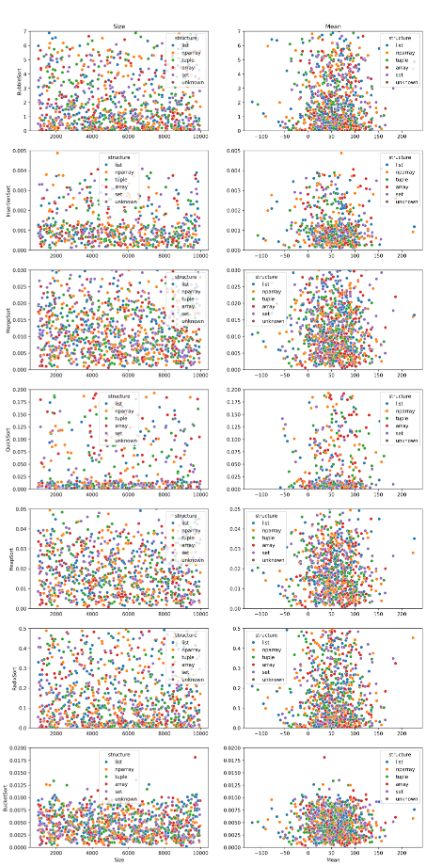

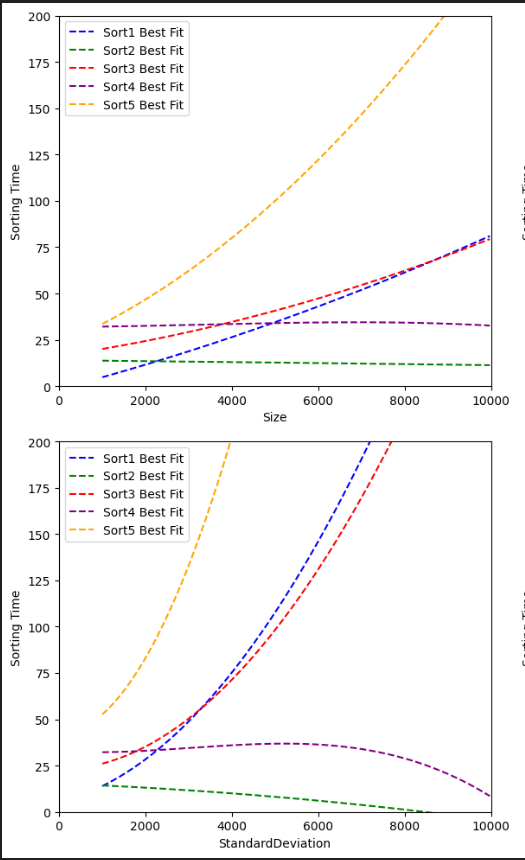

Another roadblock we ran into while timing our algorithms was that Panda Series were extremely slow compared to the other data structures. We initially included them to provide some extra data for the model to train on, but quickly realized they heavily limited the amount of data we could process with the sorting algorithms, thus we decided to remove them from the data entirely. 


# KEEP OR REMOVE THIS SECTION??????
Thus, we chose to pivot to using only algorithms which had similar time complexities. After doing some research, we found that Heap Sort and Merge Sort had O(n log n) for all cases and Quick Sort had O(n log n) except for in the worst case where it is O(n^2). We made the decision to move forward with only data from these three algorithms, as otherwise we would never be able to train a useful model as the answer could be easily seen from the data with the naked eye. While this would hamper our results moving forward, we felt we could still find useful information about the array's from the more limited scope of the algorithms. 

### Data Processing

Once we were happy with the state of our data, we moved onto preprocessing our data. We felt there wasn't too much we could perform to improve the model's performance, and thus we decided to mainly focus on standardizing our very large features. Having numbers well into the thousands would only prove to hamper a model's performance, so we standardized each row according to how we learned during the course, as shown below. 

In [ ]:
features_list = load_features()

features = np.array(features_list)
features = features[:-1, :]
features_to_standardize = features[:, :4]

floats = features_to_standardize.astype(float)
standardized = standardize(floats)

print("Standard Deviation of each Row should be 1: ", np.std(standardized, axis=0))
print("Mean of each Row should be 0: ", np.round(np.mean(standardized, axis=0)))

features[:, 0:4] = standardized

### Model Selection
Our initial idea for a model was a TensorFlow nueral network. The idea was that would preform the best on data that was not highly correlated. The neural network we implemented is shown in the code cell below. With the original real world data, the network was only acheiving around 60% accuracy. After training it on our synthetic data, accuracy for the nureal network increased to slightly over 80%. We decided to experiment with other models, including SVM and kNN with grid search in an attempt to improve the accuracy of our model. 

Epoch 1/40


c:\Users\aborc\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2456 - loss: 9.6030 - val_accuracy: 0.8000 - val_loss: 0.6258
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8010 - loss: 0.5498 - val_accuracy: 0.7850 - val_loss: 0.5597
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7849 - loss: 0.6181 - val_accuracy: 0.7900 - val_loss: 0.5341
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7696 - loss: 0.6198 - val_accuracy: 0.8250 - val_loss: 0.5739
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8090 - loss: 0.5238 - val_accuracy: 0.8050 - val_loss: 0.5504
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8377 - loss: 0.5246 - val_accuracy: 0.7900 - val_loss: 0.5695
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.5656 - val_accuracy: 0.8150 - val_loss: 0.5450
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8076 - loss: 0.5779 - val_accuracy: 0.8350 - val_loss: 0.5434
Ep

c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


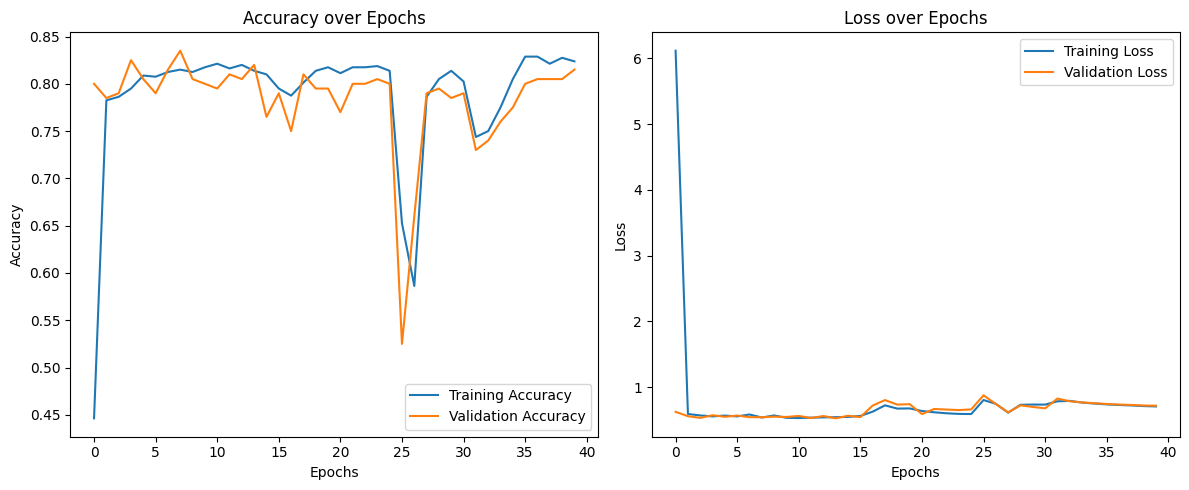

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout
from keras.api.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./data/mock_timings.csv')

features = ['Size', 'StandardDeviation', 'NumUnique']
sorts = ['Sort1', 'Sort2', 'Sort3', 'Sort4', 'Sort5']

df['BestSort'] = df[sorts].idxmin(axis=1)

X = df[features]
y = df['BestSort']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu')
])

optimizer = Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=40, batch_size=32, validation_data=(X_test_scaled, y_test))

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()